In [11]:
import tensorflow as tf
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt

# MLP w TensorFlow

  * Jak można było się spodziewać, TensorFlow ma wiele przydatnych funkcji do tworzenia standardowych warstw sieci neuronowych, więc często nie ma potrzeby definiowania własnej funkcji **neuron_layer()**. 
  * Na przykład funkcja **tf.layers.dense()** tworzy warstwę, w której wszystkie wejścia są połączone ze wszystkimi neuronami w warstwie. 
  * Dba o tworzenie zmiennych wag i bias z odpowiednią strategią inicjalizacji i domyślnie korzysta z funkcji aktywacji **ReLU** (możemy to zmienić za pomocą argumentu **activation_fn**). 

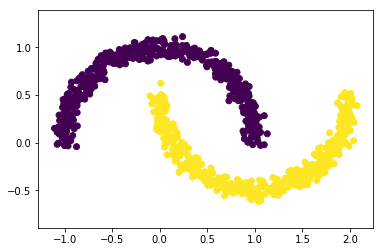

In [12]:
data_X, data_y = sklearn.datasets.make_moons(n_samples=1000, noise=.05)



plt.scatter(data_X[:,0],data_X[:,1],c=data_y)
plt.axis('equal')
plt.show()

In [13]:

tf.reset_default_graph()

n_inputs = 2
n_hidden1 = 100
n_hidden2 = 100
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

he_init = tf.contrib.layers.variance_scaling_initializer()

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu, kernel_initializer=he_init)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu, kernel_initializer=he_init)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")        
        
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")   
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)    
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    
    

In [16]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

from sklearn.utils import shuffle

n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        X1, y1 = shuffle(data_X, data_y)
        X_batches = np.array_split(X1, (data_X.shape[0] // batch_size))    
        y_batches = np.array_split(y1, (data_X.shape[0] // batch_size)) 
        for batch_index in range(data_X.shape[0] // batch_size):
            print("\r{}%".format(100 * batch_index //  (data_X.shape[0] // batch_size) ), end="")

            X_batch = X_batches[batch_index]
            y_batch = y_batches[batch_index]
            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: data_X, y: data_y})
        print(" ", epoch, "Train accuracy:", acc_train) 
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")
        

95%  0 Train accuracy: 0.853
95%  1 Train accuracy: 0.879
95%  2 Train accuracy: 0.882
95%  3 Train accuracy: 0.883
95%  4 Train accuracy: 0.881
95%  5 Train accuracy: 0.881
95%  6 Train accuracy: 0.882
95%  7 Train accuracy: 0.883
95%  8 Train accuracy: 0.885
95%  9 Train accuracy: 0.886
95%  10 Train accuracy: 0.884
95%  11 Train accuracy: 0.886
95%  12 Train accuracy: 0.881
95%  13 Train accuracy: 0.886
95%  14 Train accuracy: 0.888
95%  15 Train accuracy: 0.887
95%  16 Train accuracy: 0.885
95%  17 Train accuracy: 0.886
95%  18 Train accuracy: 0.886
95%  19 Train accuracy: 0.891
95%  20 Train accuracy: 0.892
95%  21 Train accuracy: 0.891
95%  22 Train accuracy: 0.888
95%  23 Train accuracy: 0.891
95%  24 Train accuracy: 0.893
95%  25 Train accuracy: 0.898
95%  26 Train accuracy: 0.895
95%  27 Train accuracy: 0.904
95%  28 Train accuracy: 0.9
95%  29 Train accuracy: 0.903
95%  30 Train accuracy: 0.902
95%  31 Train accuracy: 0.904
95%  32 Train accuracy: 0.908
95%  33 Train accuracy

INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


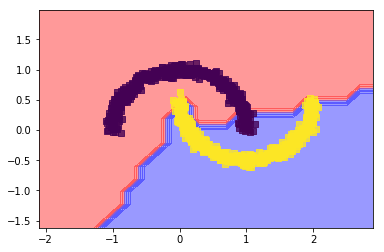

In [17]:
from matplotlib.colors import ListedColormap
# plot the decision surface
x1_min, x1_max = data_X[:, 0].min() - 1, data_X[:, 0].max() + 1
x2_min, x2_max = data_X[:, 1].min() - 1, data_X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.2), np.arange(x2_min, x2_max, 0.2))

with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt") # or better, use save_path
    
    X_new_scaled = np.array([xx1.ravel(), xx2.ravel()]).T
    Z = logits.eval(feed_dict={X: X_new_scaled})
    Z = np.argmax(Z, axis=1)
    
    #Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(data_y))])    
plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())

# plot all samples
X_test, y_test = data_X, data_y
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=data_X[:, 0], y=data_X[:, 1], alpha=0.8, c=data_y, marker=markers[idx], label=cl)
plt.show()